# Plot work by eddy momentum fluxes (Figure 7)

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pylab as pylab

In [18]:
import numpy as np
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar

In [19]:
# Filter Specs
filter_fac = 32

run = 'nw2_0.03125deg_N15_baseline_hmix20'
basepath = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
workpath = '/glade/work/noraloose/' 

In [20]:
st = xr.open_dataset('%s/%s/static.nc' % (basepath,run), decode_times=False)

# for 500 day averages
ds_lorenz = xr.open_dataset('%s/%s/lorenz_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)
ds_bleck = xr.open_dataset('%s/%s/bleck_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)

### Prepare NeverWorld2 grid info

In [21]:
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
         }

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y')

## Plotting

In [22]:
extent = [0, 60, -70, 70]

In [23]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

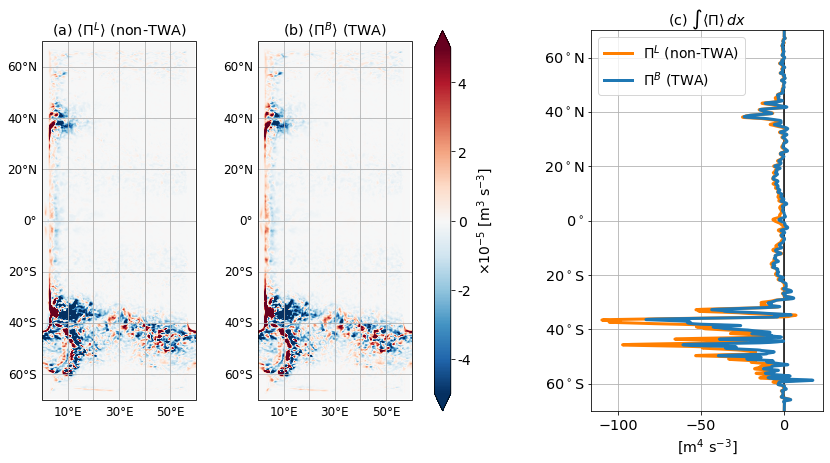

In [24]:
extent = [0, 60, -70, 70]
vmax = 0.00005
vmin = -vmax

fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(1, 40)

# non-TWA
fld = 'work_eddy_momentum_fluxes'
lb = r'(a) $\langle\Pi^L\rangle$ (non-TWA)'
ax0 = fig.add_subplot(gs[0, 0:8],  projection=ccrs.PlateCarree())

p = ds_lorenz[fld].where(st.wet).plot(
    ax=ax0, 
    vmax=vmax, vmin=-vmax, cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree()
) 
ax0.set(title = lb)

# TWA
fld = 'work_eddy_momentum_fluxes_TWA'
lb = r'(b) $\langle\Pi^B\rangle$ (TWA)'
ax1 = fig.add_subplot(gs[0, 11:19],  projection=ccrs.PlateCarree())

p = ds_bleck[fld].where(st.wet).plot(
    ax=ax1, 
    vmax=vmax, vmin=-vmax, cmap='RdBu_r',
    add_colorbar=False,
    transform=ccrs.PlateCarree()
) 
ax1.set(title = lb)

for ax in [ax0, ax1]:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
# colorbar
cax = fig.add_subplot(gs[0, 20])
cb = fig.colorbar(p, cax=cax, extend='both', ticks=1e-5*np.arange(-4,5,2))
cb.ax.tick_params(labelsize=14)
cb.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]',size=14)#, y=0.45)
cb.ax.set_yticklabels(['-4','-2','0','2','4'])

# zonal integrals
ax2 = fig.add_subplot(gs[0, 28:40])
fldlist = ['work_eddy_momentum_fluxes', 'work_eddy_momentum_fluxes_TWA']
dslist = [ds_lorenz, ds_bleck]
labellist = [r'$\Pi^L$ (non-TWA)', r'$\Pi^B$ (TWA)']
colorlist = ['#ff7f00', '#1f78b4']

for fld, ds, label, color in zip(fldlist, dslist, labellist, colorlist):
    (ds[fld] * st.dxT).sum(dim='xh').plot(ax=ax2, y='yh', linewidth=3, label=label, color=color)

ax2.vlines(0, -70, 70, color='k')
ax2.legend()
ax2.grid()
ax2.legend(fontsize=14)
ax2.grid('on')
ax2.set(ylabel='', xlabel=r'[m$^4$ s$^{-3}$]', title=r'(c) $\int \langle\Pi\rangle \, dx$')
ax2.set_yticks(ticks=np.arange(-60, 60.1, 20))
ax2.set(yticklabels=[r'60$^\circ$S', r'40$^\circ$S', r'20$^\circ$S',  r'0$^\circ$',  r'20$^\circ$N', r'40$^\circ$N', r'60$^\circ$N'])
ax2.set_ylim(-70, 70)

figname = 'figures/work_eddy_momentum_fluxes_fac%i.png' %filter_fac
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)